In [32]:
# AndroidWorld 轨迹可视化

# 这个 notebook 用于可视化 `runs/diy_0123_v2_split2` 下的轨迹：

# - 展示 **Goal(指令)** + **整条轨迹**
# - 每个 step：展示 `screenshot_step{n}.png`，并 `print` 对应的 `model_response`（即 `result.json` 里的 `trajectory[n].response`）
# - 若该 step 的 tool call 是 `click` 或 `long_press`，在截图上用 **红色圆圈** 标注点击点


from __future__ import annotations

from pathlib import Path
import json
import re

from PIL import Image, ImageDraw
from IPython.display import display, Markdown

RUNS_DIR = Path("/Users/chengkanzhi/Desktop/ScaleCUA/evaluation/AndroidWorld/runs/diy_0123_v2_split2")

_TOOL_RE = re.compile(r"<tool_call>\s*(\{.*?\})\s*</tool_call>", re.DOTALL)


def _extract_click_actions(response_text: str):
    """从 response 里抽取 click/long_press。

    注意：AndroidWorld 的坐标是归一化到 [0, 1000] 的。
    """

    actions = []
    for m in _TOOL_RE.finditer(response_text or ""):
        try:
            call = json.loads(m.group(1))
        except Exception:
            continue

        args = (call or {}).get("arguments") or {}
        action = args.get("action")
        if action not in {"click", "long_press"}:
            continue

        coord = args.get("coordinate")
        if isinstance(coord, (list, tuple)) and len(coord) == 2:
            # 坐标归一化到 0-1000
            actions.append({"action": action, "x_norm": float(coord[0]), "y_norm": float(coord[1])})

    return actions


def _annotate_clicks(img: Image.Image, actions):
    if not actions:
        return img

    img = img.convert("RGBA")
    draw = ImageDraw.Draw(img)
    w, h = img.size
    r = max(10, int(min(w, h) * 0.03))
    stroke = max(3, r // 4)

    for a in actions:
        x = int(round(a["x_norm"] / 1000.0 * w))
        y = int(round(a["y_norm"] / 1000.0 * h))
        draw.ellipse((x - r, y - r, x + r, y + r), outline=(255, 0, 0, 255), width=stroke)

    return img


def _resize_for_display(img: Image.Image, scale: float = 0.2) -> Image.Image:
    if scale >= 1:
        return img
    w, h = img.size
    nw, nh = max(1, int(w * scale)), max(1, int(h * scale))
    resample = getattr(Image, "Resampling", Image).LANCZOS
    return img.resize((nw, nh), resample)


def show_trajectory(traj_dir: Path, max_steps: int | None = None, display_scale: float = 0.2):
    """展示某条轨迹：每步截图 + response，并对 click/long_press 标注红圈。

    display_scale: 显示缩放比例（默认 1/5）。
    """

    data = json.loads((traj_dir / "result.json").read_text(encoding="utf-8"))
    goal = data.get("goal", "")
    display(Markdown(f"## {traj_dir.name}\n\n**Goal**: {goal}"))

    traj = data.get("trajectory") or []
    if max_steps is not None:
        traj = traj[: max_steps]

    for item in traj:
        step = item.get("step")
        response = item.get("response", "")
        actions = _extract_click_actions(response)

        display(Markdown(f"### Step {step}"))

        img_path = None
        for p in sorted(traj_dir.glob(f"screenshot_step{step}.*")):
            img_path = p
            break

        if img_path and img_path.exists():
            img = Image.open(img_path)
            img = _annotate_clicks(img, actions)
            display(_resize_for_display(img, display_scale))
        else:
            print(f"[缺少截图] step={step}")

        print(response)
        print("-" * 80)


## 416_AudioRecorderRecordAudioWithFileName

**Goal**: In the Audio Recorder app, change the interface theme to Orange, configure the recording format to Wav with a 44.1kHz sample rate and Mono channel count, and then apply these settings.

### Step 0

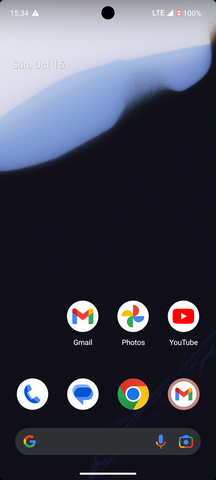

<thinking>
I need to open the "Audio Recorder" app to change the settings as requested. Since the app is not visible on the home screen, I will swipe up to access the app drawer.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "swipe", "coordinate": [500, 800], "coordinate2": [500, 200]}}
</tool_call>
--------------------------------------------------------------------------------


### Step 1

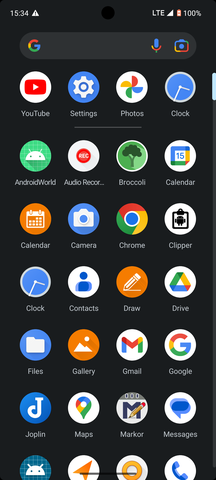

<thinking>
I have successfully opened the app drawer and located the "Audio Recorder" app. Now, I will tap on the app icon to launch it so I can access its settings and make the requested changes.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "click", "coordinate": [387, 325]}}
</tool_call>
--------------------------------------------------------------------------------


### Step 2

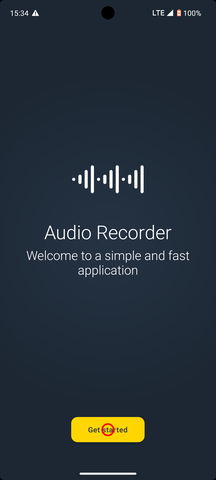

<thinking>
I am currently on the welcome screen of the Audio Recorder app. To proceed to the main interface and access the settings, I need to tap the "Get started" button.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "click", "coordinate": [499, 895]}}
</tool_call>
--------------------------------------------------------------------------------


### Step 3

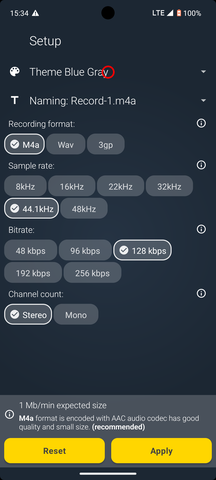

<thinking>
I am on the Setup screen of the Audio Recorder app. I need to configure the settings as requested: Theme to Orange, Recording format to Wav, Sample rate to 44.1kHz, and Channel count to Mono.
First, I will open the Theme selection menu by tapping on the "Theme Blue Gray" option.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "click", "coordinate": [500, 150]}}
</tool_call>
--------------------------------------------------------------------------------


### Step 4

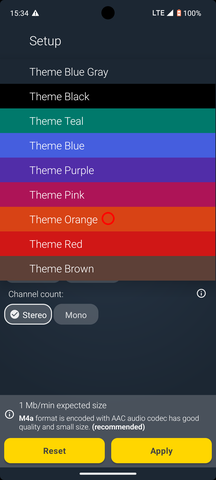

<thinking>
I need to select the "Theme Orange" from the dropdown list. Based on the visual layout in the third screenshot, the "Theme Orange" option is the seventh item in the list. I will tap on the center of the orange band to select it.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "click", "coordinate": [500, 455]}}
</tool_call>
--------------------------------------------------------------------------------


### Step 5

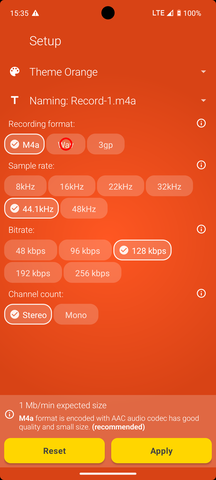

<thinking>
The theme has been successfully changed to Orange as seen in the latest screenshot. Now I need to configure the recording format to Wav. Currently, "M4a" is selected. I will tap on the "Wav" option to select it. The sample rate is already set to 44.1kHz, so I don't need to change that. After selecting Wav, I will proceed to change the channel count.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "click", "coordinate": [305, 300]}}
</tool_call>
--------------------------------------------------------------------------------


### Step 6

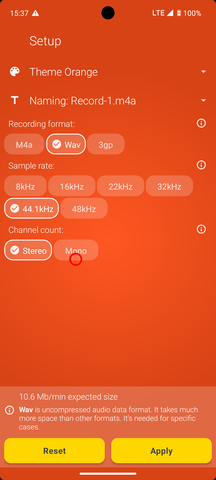

<thinking>
The user wants to change the channel count to "Mono". Currently, "Stereo" is selected. Based on the latest screenshot, the "Mono" button is located to the right of the "Stereo" button under the "Channel count" section. The "Bitrate" section has disappeared because "Wav" format was selected, shifting the "Channel count" section up. I estimate the coordinates for the "Mono" button to be approximately X=350 and Y=540. After selecting Mono, I will need to apply the settings.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "click", "coordinate": [350, 540]}}
</tool_call>
--------------------------------------------------------------------------------


### Step 7

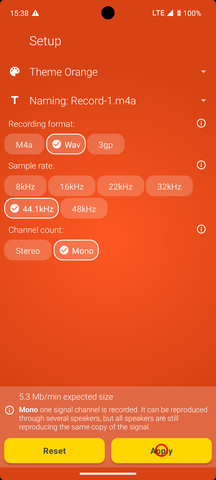

<thinking>
All the requested settings have been configured: Theme is Orange, Recording format is Wav, Sample rate is 44.1kHz, and Channel count is Mono. The final step is to apply these changes. I will tap the "Apply" button located at the bottom right of the screen.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "click", "coordinate": [747, 938]}}
</tool_call>
--------------------------------------------------------------------------------


### Step 8

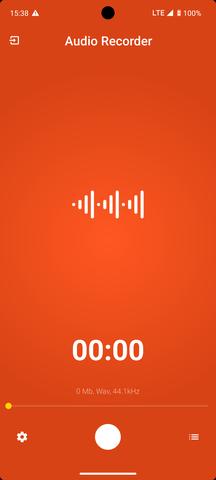

<thinking>
The latest screenshot shows the main interface of the Audio Recorder app with an orange background, confirming the theme change. The text "0 Mb, Wav, 44.1kHz" is visible above the recording timeline, confirming the recording format and sample rate settings. The previous steps indicate that "Mono" was selected and the "Apply" button was pressed, which transitioned the app to this screen. All requested configuration changes have been made and applied.
</thinking>
<tool_call>
{"name": "mobile_use", "arguments": {"action": "terminate", "status": "success"}}
</tool_call>
--------------------------------------------------------------------------------


PosixPath('/Users/chengkanzhi/Desktop/ScaleCUA/evaluation/AndroidWorld/runs/diy_0123_v2_split2/416_AudioRecorderRecordAudioWithFileName')

In [34]:
import random


def list_trajectories(runs_dir: Path = RUNS_DIR):
    return sorted([p for p in runs_dir.iterdir() if p.is_dir() and (p / "result.json").exists()])


def show_random_trajectory(
    runs_dir: Path = RUNS_DIR,
    max_steps: int | None = None,
    seed: int | None = None,
    display_scale: float = 0.2,
):
    if seed is not None:
        random.seed(seed)

    trajs = list_trajectories(runs_dir)
    if not trajs:
        raise FileNotFoundError(f"未找到轨迹目录：{runs_dir}")

    traj_dir = random.choice(trajs)
    show_trajectory(traj_dir, max_steps=max_steps, display_scale=display_scale)
    return traj_dir


# 每次运行随机抽一条展示（默认缩小到 1/5）
show_random_trajectory()